# 두 스타일 이미지 → 하나의 콘텐츠 이미지

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

In [2]:
# 이미지 로드 함수 (스타일 처리 전 처리 / 전처리)
def load_image(img_url, max_size=400, shape=None):
  response = requests.get(img_url)
  image = Image.open(BytesIO(response.content)).convert('RGB')
  if shape:
    image = image.resize(shape, Image.LANCZOS)
  else:
    image.thumbnail((max_size, max_size))
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return transform(image).unsqueeze(0)

In [3]:
# 이미지 처리 함수 (스타일 처리 후 처리 / 후처리)
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach().squeeze()
  image = image.numpy().transpose(1, 2, 0)
  image = image * [0.229, 0.224, 0.225]
  image = image + [0.485, 0.456, 0.406]
  return image.clip(0, 1)

In [4]:
# 특징 추출 함수
def get_features(image, model):
  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2',
      '28': 'conv5_1'
  }
  features = {}

  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      features[layers[name]] = x

  return features

In [5]:
# 스타일 표현을 위한 행렬(채널 간 관계) 계산 함수
def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h * w)
  return torch.mm(tensor, tensor.t())

In [6]:
# 스타일 믹싱 함수
def style_transfer_mix(content, style1, style2, model, mix_ratio=0.5, steps=200, content_weight=1, style_weight=1e6):
  with torch.no_grad():
    content_features = get_features(content, model)
    style1_features = get_features(style1, model)
    style2_features = get_features(style2, model)

    style_grams_mix = {}
    for i in style1_features:
      gram1 = gram_matrix(style1_features[i])
      gram2 = gram_matrix(style2_features[i])
      style_grams_mix[i] = mix_ratio * gram1 + (1 - mix_ratio) * gram2

  target = content.clone().requires_grad_(True)
  optim = torch.optim.Adam([target], lr=0.003)

  for i in range(steps):
    target_features = get_features(target, model)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for j in style_grams_mix:
      target_gram = gram_matrix(target_features[j])
      style_gram = style_grams_mix[j]
      layer_loss = torch.mean((target_gram - style_gram) ** 2)
      style_loss += layer_loss / (target_features[j].shape[1] ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    optim.zero_grad()
    total_loss.backward()
    optim.step()

  return target

In [7]:
# 이미지 URL
content_url = "https://images.theconversation.com/files/625049/original/file-20241010-15-95v3ha.jpg?ixlib=rb-4.1.0&rect=12%2C96%2C2671%2C1335&q=45&auto=format&w=1356&h=668&fit=crop"
style1_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style2_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"

In [8]:
# 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = models.vgg19(pretrained=True).features.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
content = load_image(content_url).to(device)
style1 = load_image(style1_url, shape=content.shape[-2:]).to(device)
style2 = load_image(style2_url, shape=content.shape[-2:]).to(device)

In [10]:
result = style_transfer_mix(content, style1, style2, vgg)

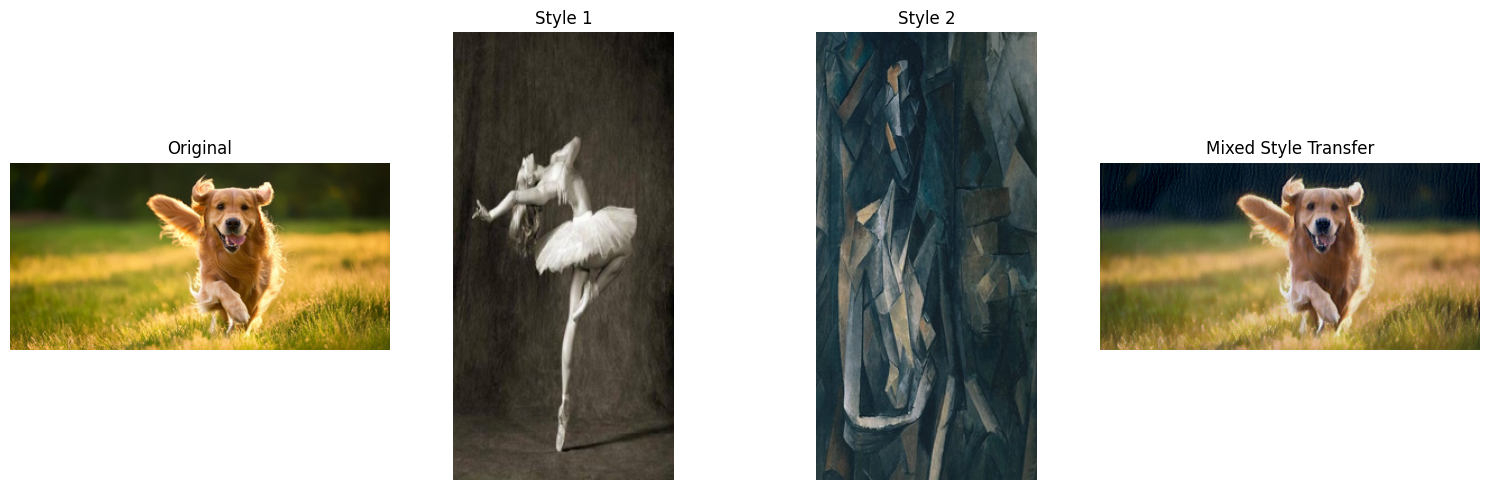

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(im_convert(content))
plt.title('Original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(im_convert(style1))
plt.title('Style 1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(im_convert(style2))
plt.title('Style 2')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(im_convert(result))
plt.title('Mixed Style Transfer')
plt.axis('off')

plt.tight_layout()
plt.show()